# ReadMe

0) Functions for loading an experiment results (various pairs, various betas => dictionary)

1) sDice (#n_slices) => the optimal n_slices = 7

2) sDice (beta) => looking for optimal betas on Val => Test results with optimal betas



# Miscellaneous

In [1]:
import sys
sys.path.append('/path/k_space_da_main/')

import numpy as np
from os.path import join as jp
import matplotlib.pyplot as plt
import os
import pickle
import json

from configs.assets.kswap import *
from dpipe.torch.utils import load_model_state
from dpipe.io import load
from kswap.module.unet import UNet2D

from torch.fft import rfft2, irfft2

from matplotlib.colors import LogNorm

from kswap.easy_swapping import MRIs

In [2]:
# pair to the number of an experiment in the split

id2dom = {0: 'sm15', 1: 'sm3', 2: 'ge15', 3: 'ge3', 4: 'ph15', 5: 'ph3'}
pairs = [(1, 2), (3, 5), (5, 2), (0, 5), (5, 0), (2, 4)]

count = 0
pair2exp = {}
for i in range(6):
    for j in range(6):
        if i!=j:
            pair2exp[(i,j)] = count
            count += 1
            
exps = [pair2exp[el] for el in pairs]

# Functions for loading results of the experiments

In [3]:
def func_sort(x):
    """
    file name format: 0.01.json
    func_sort(0.01.json) = 0.01
    """
    return float(x.split('j')[0][:-1])
    

def get_swap_res(path):
    """
    a function for collecting results
    """
    global_res = {}
    pairs = os.listdir(path)
    for pair in pairs: 

        pair_dir = os.path.join(path, pair)
        global_res[pair] = {}
        global_res[pair]['betas'] = []
        global_res[pair]['scores'] = []

        beta_exps = sorted(os.listdir(pair_dir), key=func_sort)
        for exp in beta_exps:
            beta = func_sort(exp)  
            exp_dir = os.path.join(pair_dir, exp)
            res = load(exp_dir)
            score = np.array(list(res.values())).mean()
            global_res[pair]['betas'].append(beta)
            global_res[pair]['scores'].append(score)
            
    return global_res

In [4]:
pairs = ['sm3_ge15', 'ge3_ph3', 'ph3_ge15', 'sm15_ph3', 'ph3_sm15', 'ge15_ph15']

# sDice (#n_slices); 3D slice picking

In [5]:
n_slices = [1, 3, 5, 7, 11, 15]
dir_names = ['/path/exps/naive_swap/val_ensemble_best_n_' + str(n) + '_3d'
             for n in n_slices]
results = [get_swap_res(addr) for addr in dir_names]

In [6]:
# getting all the results in one dictionary
res_ens = {}
for pair in pairs:
    res_ens[pair] = {}
    for beta in np.arange(0.005, 0.025, 0.005):
        res_ens[pair][beta] = {}
        for i, n_res in enumerate(results):
            id_score = n_res[pair]['betas'].index(beta)
            res_ens[pair][beta][i] = n_res[pair]['scores'][id_score]

In [7]:
# averaging results over different pairs
res_ens_av = {}
for beta in np.arange(0.005, 0.025, 0.005):
    res_ens_av[beta] = {}
    for i in range(6):
        res_ens_av[beta][i] = []
        for pair in pairs:
            res_ens_av[beta][i].append(res_ens[pair][beta][i])
        res_ens_av[beta][i] = np.array(res_ens_av[beta][i]).mean()

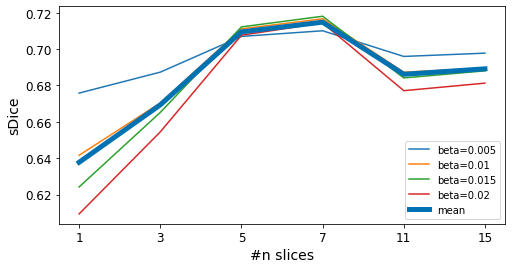

In [8]:
plt.figure(figsize=(8,4))

ns = [str(el) for el in n_slices]
vals_global = []
for beta in res_ens_av:
    res_ens_av_beta = res_ens_av[beta]
    vals = []
    for i in range(6):
        vals.append(res_ens_av_beta[i])
    vals_global.append(vals)
    plt.plot(ns, vals, label = 'beta=' + str(beta))
vals_global = np.array(vals_global).mean(axis=0)
plt.plot(ns, vals_global, label = 'mean',linewidth=5.0,c=u'#0072B2')
    
plt.xlabel('#n slices', fontsize=14)
plt.ylabel('sDice', fontsize=14)
plt.ylabel('sDice', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('im1.png', dpi=150)
plt.show()

# sDice(beta); n=7

## Loading what is necessary

In [9]:
base_dir = '/path/exps/naive_swap/val_ensemble_best_n_7_2d'
global_res_ensemble_best_7_2d = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/val_ensemble_best_n_7_25d'
global_res_ensemble_best_7_25d = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/val_ensemble_best_n_7_3d'
global_res_ensemble_best_7_3d = get_swap_res(base_dir)

# Random Ensemble
base_dir = '/path/exps/naive_swap/val_ensemble'
global_res_ensemble = get_swap_res(base_dir)

# Random Source Slice
base_dir = '/path/exps/naive_swap/val'
global_res = get_swap_res(base_dir)

all_res = [global_res_ensemble_best_7_2d, global_res_ensemble_best_7_25d, global_res_ensemble_best_7_3d,
          global_res_ensemble, global_res]

all_res_names = ['2d', '25d', '3d', 'mst', 'none']

In [10]:
clrs = {'sm3_ge15': 'r', 'ge3_ph3': 'g', 'ph3_ge15': 'b', 'sm15_ph3': 'm', 'ph3_sm15': 'c',
        'ge15_ph15': 'y'}

## Plotting

In [11]:
def plot_sdice (axis, results, n_plot, n_x):
    res_pair_global = []
    for i, el in enumerate(results):

        res_pair = results[el]
        axis[n_plot].plot(res_pair['betas'][:n_x], res_pair['scores'][:n_x], 
                    label = el.split('_')[0] + ' -> ' + el.split('_')[1], c=clrs[el], linewidth=4.0) #, marker='o')
        beta_n = np.array(res_pair['scores']).argmax()
        if beta_n == 0:
            beta_n = 1
        axis[n_plot].scatter(res_pair['betas'][beta_n], res_pair['scores'][beta_n], c=clrs[el], linewidth=8.0)
        res_pair_global.append(res_pair['scores'][:n_x])

    res_pair_global = np.array(res_pair_global).mean(axis=0)
    axis[n_plot].plot(res_pair['betas'][:n_x], res_pair_global, 
                label = 'mean', c=u'#0072B2', linewidth=6.0) #, marker='o')
    beta_n = np.array(res_pair_global).argmax()
    if beta_n == 0:
        beta_n = 1
    axis[n_plot].scatter(res_pair['betas'][beta_n], res_pair_global[beta_n], c=u'#0072B2', linewidth=15.0)

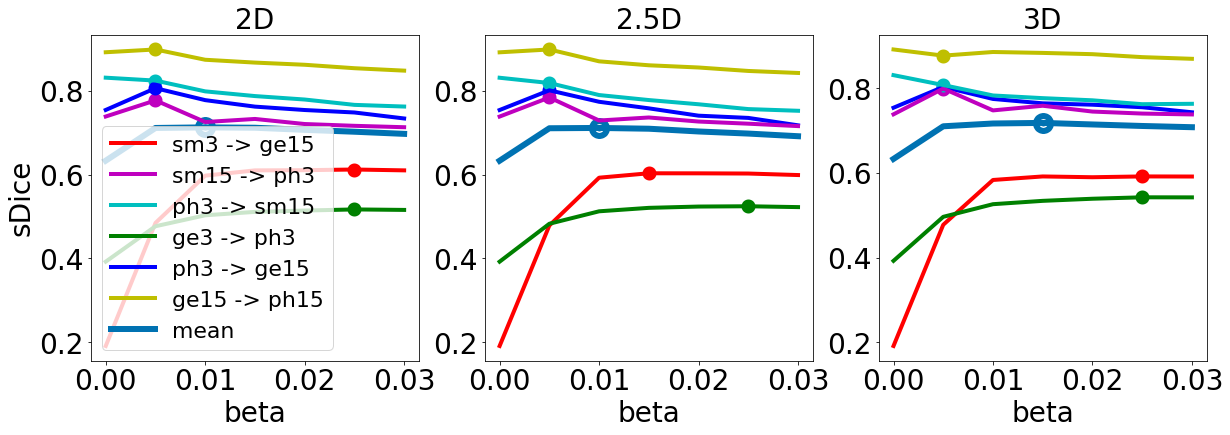

In [12]:
figure, axis = plt.subplots(1, 3, figsize=(20,6))
n_x = 7

plot_sdice (axis, global_res_ensemble_best_7_2d, 0, n_x)
plot_sdice (axis, global_res_ensemble_best_7_25d, 1, n_x)
plot_sdice (axis, global_res_ensemble_best_7_3d, 2, n_x)

axis[0].set_ylabel('sDice', fontsize=28)

for i in range(3):
    axis[i].set_xlabel('beta', fontsize=28)
    axis[i].set_xticks([0, 0.01, 0.02, 0.03])
    axis[i].tick_params(labelsize=28)

axis[0].legend(fontsize=22, loc=3)
axis[0].set_title('2D', fontsize=28)
axis[1].set_title('2.5D', fontsize=28)
axis[2].set_title('3D', fontsize=28)

plt.savefig('im2.png', dpi=150)
plt.show()

## The Optimal Betas (validation)

### Average

In [13]:
def global_avg (results, n_x):

    res_pair_global = []
    for i, el in enumerate(results):

        res_pair = results[el]
        res_pair_global.append(np.array(res_pair['scores'][:n_x]))
    
    res_pair_global = np.array(res_pair_global).mean(axis=0)    
    beta_n = np.array(res_pair_global).argmax()
    if beta_n == 0:
        beta_n = 1

    betas = results[pairs[0]]['betas'][:n_x]
    return betas, res_pair_global, betas[beta_n]

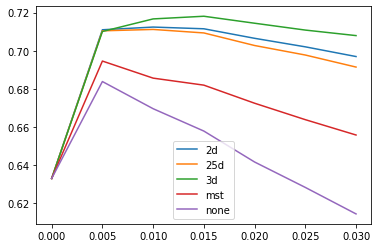

In [14]:
best_betas_global = {}
n_x = 7
for i, res in enumerate(all_res):
    name = all_res_names[i]
    betas, scores, beta_best = global_avg(res, n_x)
    best_betas_global[name] = beta_best
    plt.plot(betas, scores, label=name)
plt.legend()
plt.show()

In [15]:
best_betas_global

{'2d': 0.01, '25d': 0.01, '3d': 0.015, 'mst': 0.005, 'none': 0.005}

### Per pair

In [16]:
def per_pair_avg (results, n_x):
    
    best_betas = {}
    for i, pair in enumerate(results):
        best_betas[pair] = {}

        res_pair = np.array(results[pair]['scores'][:n_x])
        betas = results[pair]['betas'][:n_x]
        beta_best = betas[res_pair.argmax()]
        if beta_best == 0:
            beta_best = betas[1]
        best_betas[pair] = beta_best
        
    return best_betas

In [17]:
best_betas_per_pair = {}
for i, res in enumerate(all_res):
    best_betas_per_pair[all_res_names[i]] = per_pair_avg(res, n_x)

In [18]:
best_betas_per_pair

{'2d': {'sm3_ge15': 0.025,
  'sm15_ph3': 0.005,
  'ph3_sm15': 0.005,
  'ge3_ph3': 0.025,
  'ph3_ge15': 0.005,
  'ge15_ph15': 0.005},
 '25d': {'sm3_ge15': 0.015,
  'ge3_ph3': 0.025,
  'ph3_ge15': 0.005,
  'sm15_ph3': 0.005,
  'ph3_sm15': 0.005,
  'ge15_ph15': 0.005},
 '3d': {'sm3_ge15': 0.025,
  'ge3_ph3': 0.025,
  'ph3_ge15': 0.005,
  'sm15_ph3': 0.005,
  'ph3_sm15': 0.005,
  'ge15_ph15': 0.005},
 'mst': {'sm3_ge15': 0.015,
  'ge3_ph3': 0.015,
  'ph3_ge15': 0.005,
  'sm15_ph3': 0.005,
  'ph3_sm15': 0.005,
  'ge15_ph15': 0.005},
 'none': {'sm3_ge15': 0.015,
  'ge3_ph3': 0.005,
  'ph3_ge15': 0.005,
  'sm15_ph3': 0.005,
  'ph3_sm15': 0.005,
  'ge15_ph15': 0.005}}

### All together

In [19]:
all_betas_to_check = {}

In [20]:
for exp_name in all_res_names:
    all_betas_to_check[exp_name] = {}
    for pair in pairs:
        all_betas_to_check[exp_name][pair] = list({best_betas_per_pair[exp_name][pair], 
                                                   best_betas_global[exp_name]})

In [21]:
all_betas_to_check

{'2d': {'sm3_ge15': [0.025, 0.01],
  'ge3_ph3': [0.025, 0.01],
  'ph3_ge15': [0.01, 0.005],
  'sm15_ph3': [0.01, 0.005],
  'ph3_sm15': [0.01, 0.005],
  'ge15_ph15': [0.01, 0.005]},
 '25d': {'sm3_ge15': [0.015, 0.01],
  'ge3_ph3': [0.025, 0.01],
  'ph3_ge15': [0.01, 0.005],
  'sm15_ph3': [0.01, 0.005],
  'ph3_sm15': [0.01, 0.005],
  'ge15_ph15': [0.01, 0.005]},
 '3d': {'sm3_ge15': [0.025, 0.015],
  'ge3_ph3': [0.025, 0.015],
  'ph3_ge15': [0.015, 0.005],
  'sm15_ph3': [0.015, 0.005],
  'ph3_sm15': [0.015, 0.005],
  'ge15_ph15': [0.015, 0.005]},
 'mst': {'sm3_ge15': [0.015, 0.005],
  'ge3_ph3': [0.015, 0.005],
  'ph3_ge15': [0.005],
  'sm15_ph3': [0.005],
  'ph3_sm15': [0.005],
  'ge15_ph15': [0.005]},
 'none': {'sm3_ge15': [0.015, 0.005],
  'ge3_ph3': [0.005],
  'ph3_ge15': [0.005],
  'sm15_ph3': [0.005],
  'ph3_sm15': [0.005],
  'ge15_ph15': [0.005]}}

## Test Results

In [22]:
base_dir = '/path/exps/naive_swap/test_ensemble_best_n_7_2d'
test_ensemble_best_n_7_2d = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/test_ensemble_best_n_7_25d'
test_ensemble_best_n_7_25d = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/test_ensemble_best_n_7_3d'
test_ensemble_best_n_7_3d = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/test_ensemble_n_7'
test_ensemble_n_7 = get_swap_res(base_dir)

base_dir = '/path/exps/naive_swap/test_random'
test_random = get_swap_res(base_dir)

In [23]:
res_all = {'3d': test_ensemble_best_n_7_3d, '25d': test_ensemble_best_n_7_25d,
          '2d': test_ensemble_best_n_7_2d, 'mst': test_ensemble_n_7,
          'none': test_random}

In [24]:
res_table = {}
for approach in res_all.keys():
    res_table[approach] = {}
    for pair in pairs:
        res_table[approach][pair] = {}
        
        beta_average = best_betas_global[approach]
        beta_per_pair = best_betas_per_pair[approach][pair]
        
        beta_average_id = res_all[approach][pair]['betas'].index(beta_average)
        beta_per_pair_id = res_all[approach][pair]['betas'].index(beta_per_pair)
        
        res_table[approach][pair]['average'] = round(res_all[approach][pair]['scores'][beta_average_id],2)
        res_table[approach][pair]['per_pair'] = round(res_all[approach][pair]['scores'][beta_per_pair_id],2)

In [25]:
res_table

{'3d': {'sm3_ge15': {'average': 0.57, 'per_pair': 0.57},
  'ge3_ph3': {'average': 0.5, 'per_pair': 0.51},
  'ph3_ge15': {'average': 0.72, 'per_pair': 0.77},
  'sm15_ph3': {'average': 0.72, 'per_pair': 0.75},
  'ph3_sm15': {'average': 0.81, 'per_pair': 0.83},
  'ge15_ph15': {'average': 0.85, 'per_pair': 0.87}},
 '25d': {'sm3_ge15': {'average': 0.57, 'per_pair': 0.58},
  'ge3_ph3': {'average': 0.48, 'per_pair': 0.48},
  'ph3_ge15': {'average': 0.73, 'per_pair': 0.77},
  'sm15_ph3': {'average': 0.69, 'per_pair': 0.74},
  'ph3_sm15': {'average': 0.81, 'per_pair': 0.83},
  'ge15_ph15': {'average': 0.83, 'per_pair': 0.86}},
 '2d': {'sm3_ge15': {'average': 0.57, 'per_pair': 0.59},
  'ge3_ph3': {'average': 0.47, 'per_pair': 0.48},
  'ph3_ge15': {'average': 0.74, 'per_pair': 0.77},
  'sm15_ph3': {'average': 0.68, 'per_pair': 0.73},
  'ph3_sm15': {'average': 0.82, 'per_pair': 0.84},
  'ge15_ph15': {'average': 0.84, 'per_pair': 0.86}},
 'mst': {'sm3_ge15': {'average': 0.41, 'per_pair': 0.57},
  '

# The Pics

## Baseline

In [26]:
# checking the folds of the scans of interest
# sm3 -> ge15: severe domain shift
id1 = 'CC0181' # just as an example of the source domain appearance
id2 = 'CC0276' # target slice
meta.loc[[id1, id2]]

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z,shape
id,,,,,,,,,
CC0181,images/CC0181_siemens_3_36_F.nii.gz,masks/CC0181_siemens_3_36_F_ss.nii.gz,1,siemens,3,1.0,1.0,1.0,"(182, 218, 182)"
CC0276,images/CC0276_ge_15_52_M.nii.gz,masks/CC0276_ge_15_52_M_ss.nii.gz,2,ge,15,1.0,1.0,1.0,"(182, 218, 182)"


In [27]:
# checking the folds of the scans of interest
# ph3 -> sm15: mild domain shift

id3 = 'CC0061' # just as an example of the source domain appearance
id4 = 'CC0156'
meta.loc[[id3, id4]]

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z,shape
id,,,,,,,,,
CC0061,images/CC0061_philips_3_55_F.nii.gz,masks/CC0061_philips_3_55_F_ss.nii.gz,5,philips,3,1.0,1.0,1.0,"(182, 218, 182)"
CC0156,images/CC0156_siemens_15_55_M.nii.gz,masks/CC0156_siemens_15_55_M_ss.nii.gz,0,siemens,15,1.0,1.0,1.0,"(182, 218, 182)"


In [28]:
pair2exp[(1,2)]

6

In [29]:
pair2exp[(5,0)]

25

In [30]:
scan1 = dataset.load_image(id1)
mask1 = dataset.load_segm(id1)

scan2 = dataset.load_image(id2)
mask2 = dataset.load_segm(id2)

scan3 = dataset.load_image(id3)
mask3 = dataset.load_segm(id3)

scan4 = dataset.load_image(id4)
mask4 = dataset.load_segm(id4)

n = scan1.shape[2]//2 

slc1 = scan1[:,:,n]
slc_mask1 = mask1[:,:,n]

slc2 = scan2[:,:,n]
slc_mask2 = mask2[:,:,n]

slc3 = scan3[:,:,n]
slc_mask3 = mask3[:,:,n]

slc4 = scan4[:,:,n]
slc_mask4 = mask4[:,:,n]

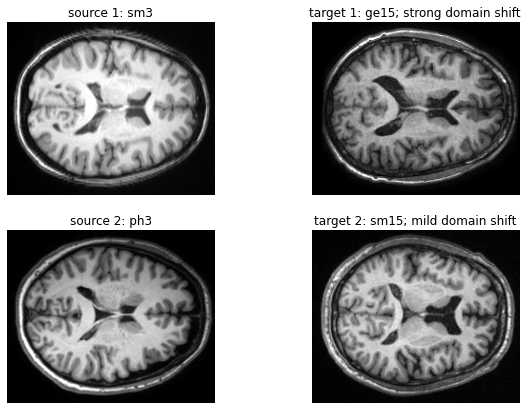

In [31]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))

axis[0,0].imshow(slc1, cmap='gray')
axis[0,1].imshow(slc2, cmap='gray')
axis[1,0].imshow(slc3, cmap='gray')
axis[1,1].imshow(slc4, cmap='gray')

axis[0,0].set_title('source 1: sm3')
axis[0,1].set_title('target 1: ge15; strong domain shift')

axis[1,0].set_title('source 2: ph3')
axis[1,1].set_title('target 2: sm15; mild domain shift')

axis[0,0].axis('off')
axis[0,1].axis('off')
axis[1,0].axis('off')
axis[1,1].axis('off')

plt.show()

## Searching for the closest scans

In [32]:
path1 = '/path/exps/closest_scans/closest_scans_test_' + str(pair2exp[(1,2)]) + '_2d.json'
path3 = '/path/exps/closest_scans/closest_scans_test_' + str(pair2exp[(5,0)]) + '_2d.json'

In [33]:
with open(path1) as fp:
    closest_val1 = json.load(fp)
with open(path3) as fp:
    closest_val3 = json.load(fp)

In [34]:
closest_scans1 = [el[0] for el in closest_val1[id2][str(n)][:7]]
closest_scans3 = [el[0] for el in closest_val3[id4][str(n)][:7]]

In [35]:
closest_scans1

['CC0209', 'CC0238', 'CC0226', 'CC0182', 'CC0199', 'CC0192', 'CC0188']

In [36]:
closest_scans3

['CC0110', 'CC0083', 'CC0067', 'CC0103', 'CC0087', 'CC0066', 'CC0097']

## Transfer

In [37]:
n_chans_in = 1
n_chans_out = 1
n_filters = 16

addr1 = '/path/exps/baseline_w_dice/experiment_1/model.pth'
addr2 = '/path/exps/baseline_w_dice/experiment_5/model.pth'

# source-trained model
model1 = UNet2D(n_chans_in=n_chans_in, n_chans_out=n_chans_out, n_filters_init=n_filters)
model1.load_state_dict(torch.load(addr1))

# target-trained model
model2 = UNet2D(n_chans_in=n_chans_in, n_chans_out=n_chans_out, n_filters_init=n_filters)
model2.load_state_dict(torch.load(addr2))

<All keys matched successfully>

In [38]:
preds1 = []
preds3 = []

for id_1, id_3 in zip(closest_scans1, closest_scans3):
    
    scan1 = dataset.load_image(id_1)
    mask1 = dataset.load_segm(id_1)
    slc1 = scan1[:,:,n]
    slc_mask1 = mask1[:,:,n]
    a = MRIs(slc1, slc2)
    new_pic1 = a.swap_low_freq_circle(beta=0.03)[0].cpu()
    pred = predict(new_pic1, net=model1)
    preds1.append(pred)
    
    scan3 = dataset.load_image(id_3)
    mask3 = dataset.load_segm(id_3)
    slc3 = scan3[:,:,n]
    slc_mask3 = mask3[:,:,n]
    a = MRIs(slc3, slc4)
    new_pic3 = a.swap_low_freq_circle(beta=0.03)[0].cpu()
    pred = predict(new_pic3, net=model2)
    preds3.append(pred)

In [39]:
pred1 = np.mean(preds1, axis=0)
pred3 = np.mean(preds3, axis=0)

In [40]:
_sdice1 = sdice_metric (pred1, slc_mask2)
_dice1 = dice_metric(pred1, slc_mask2)

_sdice2 = sdice_metric (pred3, slc_mask4)
_dice2 = dice_metric(pred3, slc_mask4)

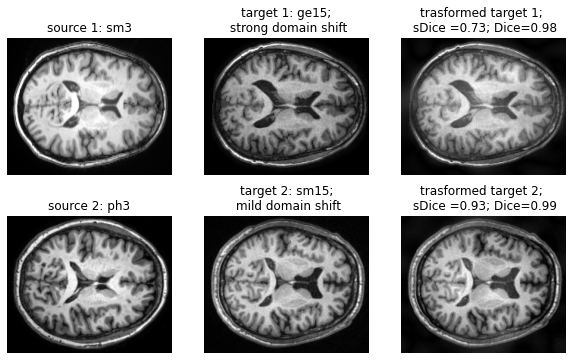

In [41]:
figure, axis = plt.subplots(2, 3, figsize=(10,6))

axis[0,0].imshow(slc1, cmap='gray')
axis[0,1].imshow(slc2, cmap='gray')
axis[0,2].imshow(new_pic1, cmap='gray')
axis[1,0].imshow(slc3, cmap='gray')
axis[1,1].imshow(slc4, cmap='gray')
axis[1,2].imshow(new_pic3, cmap='gray')

axis[0,0].set_title('source 1: sm3')
axis[0,1].set_title('target 1: ge15;\n strong domain shift')
axis[0,2].set_title('trasformed target 1; \n sDice =' + str(round(_sdice1,2)) + '; Dice=' + str(round(_dice1,2)))
axis[1,0].set_title('source 2: ph3')
axis[1,1].set_title('target 2: sm15;\n mild domain shift')
axis[1,2].set_title('trasformed target 2; \n sDice =' + str(round(_sdice2,2)) + '; Dice=' + str(round(_dice2,2)))

axis[0,0].axis('off')
axis[0,1].axis('off')
axis[1,0].axis('off')
axis[1,1].axis('off')
axis[1,2].axis('off')
axis[0,2].axis('off')

plt.show()

## Different slices of a single scan

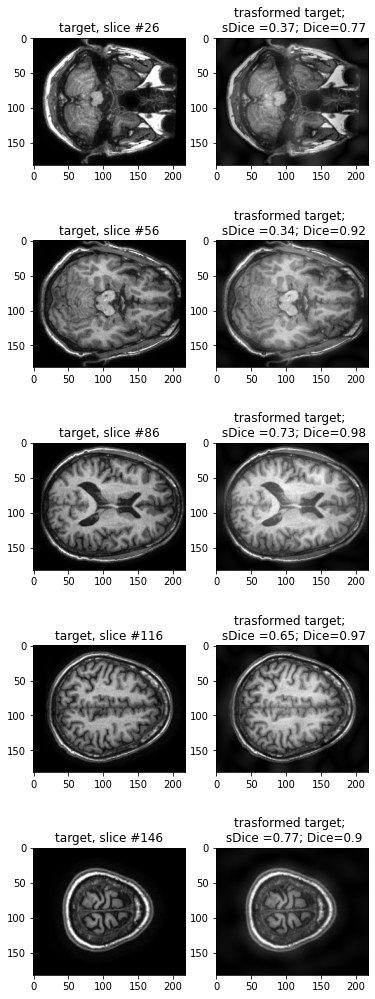

In [42]:
figure, axis = plt.subplots(5, 2, figsize=(6,18))

ns = [26, 56, 86, 116, 146]

for i, n in enumerate(ns):

    slc1 = scan1[:,:,n]
    slc_mask1 = mask1[:,:,n]

    slc2 = scan2[:,:,n]
    slc_mask2 = mask2[:,:,n]

    closest_scans1 = [el[0] for el in closest_val1[id2][str(n)][:7]]

    preds1 = []

    for id_1 in closest_scans1:

        scan1 = dataset.load_image(id_1)
        mask1 = dataset.load_segm(id_1)
        slc1 = scan1[:,:,n]
        slc_mask1 = mask1[:,:,n]
        a = MRIs(slc1, slc2)
        new_pic1 = a.swap_low_freq_circle(beta=0.03)[0].cpu()
        pred = predict(new_pic1, net=model1)
        preds1.append(pred)

    pred1 = np.mean(preds1, axis=0)

    _sdice1 = sdice_metric (pred1, slc_mask2)
    _dice1 = dice_metric(pred1, slc_mask2)
    
    axis[i,0].imshow(slc2, cmap='gray')
    axis[i,1].imshow(new_pic1, cmap='gray')
    axis[i,0].set_title('target, slice #' + str(n))
    axis[i,1].set_title('trasformed target; \n sDice =' + str(round(_sdice1,2)) + '; Dice=' + str(round(_dice1,2)))
    